Note: This notebook was run and written on Kaggle.

The necessary datasets are: 
- road-segmentation-data-loader
- road-segmentation-ds

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'road-segmentation-data-loader'))

from load_data import *
from augmentation_fncs import *

# %load_ext autoreload
# %autoreload 2

In [2]:
print(tf.version.VERSION)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[]


# 0. Read in images, preprocess and create augmentations

Source: 
- Generating tensorflow datasets: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
- Image augmentation with tensorflow: https://www.tensorflow.org/api_docs/python/tf/image

In [3]:
# Read in images from directory and create tf.data.Dataset
# Get file names
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
gts_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Since using iou loss, need to one hot encode the groundtruth images
original_dataset = create_dataset(imgs_dir, gts_dir, one_hot = True)

print(f'Loaded data set: {original_dataset}')

Loaded data set: <_MapDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>


In [4]:
def get_img_and_gt(ds):
    
    '''To get groundtruths of shape (400,400,1) from the groundtruth tensors in the dataset of shape (400,400,2)'''
    
    for img, gt in ds:        
        img = img.numpy()

        gt = tf.argmax(gt, axis=-1)
        gt = tf.cast(gt, dtype = tf.float32)
        gt = gt.numpy() 
    
    return img, gt

In [5]:
sample = original_dataset.take(1)
sample_img, sample_gt = get_img_and_gt(sample)

# Brightness related
brightness_augmented = sample.map(adjust_brightness)
brightness_augmented_img, brightness_augmented_gt = get_img_and_gt(brightness_augmented)

contrast_augmented = sample.map(adjust_contrast)
contrast_augmented_img, contrast_augmented_gt = get_img_and_gt(contrast_augmented)

saturation_augmented = sample.map(adjust_saturation)
saturation_augmented_img, saturation_augmented_gt = get_img_and_gt(saturation_augmented)

# Rotation related
flip_left_right_augmented = sample.map(flip_left_right)
flip_left_right_augmented_img, flip_left_right_augmented_gt = get_img_and_gt(flip_left_right_augmented)

flip_up_down_augmented = sample.map(flip_up_down)
flip_up_down_augmented_img, flip_up_down_augmented_gt = get_img_and_gt(flip_up_down_augmented)

rotated_augmented = sample.map(lambda img, gt: rotate_img(img, gt, 1))
rotated_augmented_img, rotated_augmented_gt = get_img_and_gt(rotated_augmented)

transposed_augmented = sample.map(transpose_img)
transposed_augmented_img, transposed_augmented_gt = get_img_and_gt(transposed_augmented)

# Noise related
gaussian_noise_augmented = sample.map(add_gaussian_noise)
gaussian_augmented_img, gaussian_augmented_gt = get_img_and_gt(gaussian_noise_augmented)

salt_pepper_augmented = sample.map(salt_and_pepper_noise)
salt_pepper_augmented_img, salt_pepper_augmented_gt = get_img_and_gt(salt_pepper_augmented)

cloud_noise_augmented = sample.map(cloud_noise)
cloud_noise_augmented_img, cloud_noise_augmented_gt = get_img_and_gt(cloud_noise_augmented)

black_patch_augmented = sample.map(black_patch_noise)
black_patch_augmented_img, black_patch_augmented_gt = get_img_and_gt(black_patch_augmented)

# 1. Visualisation of augmented images

Text(0.5, 1.0, 'Black patch')

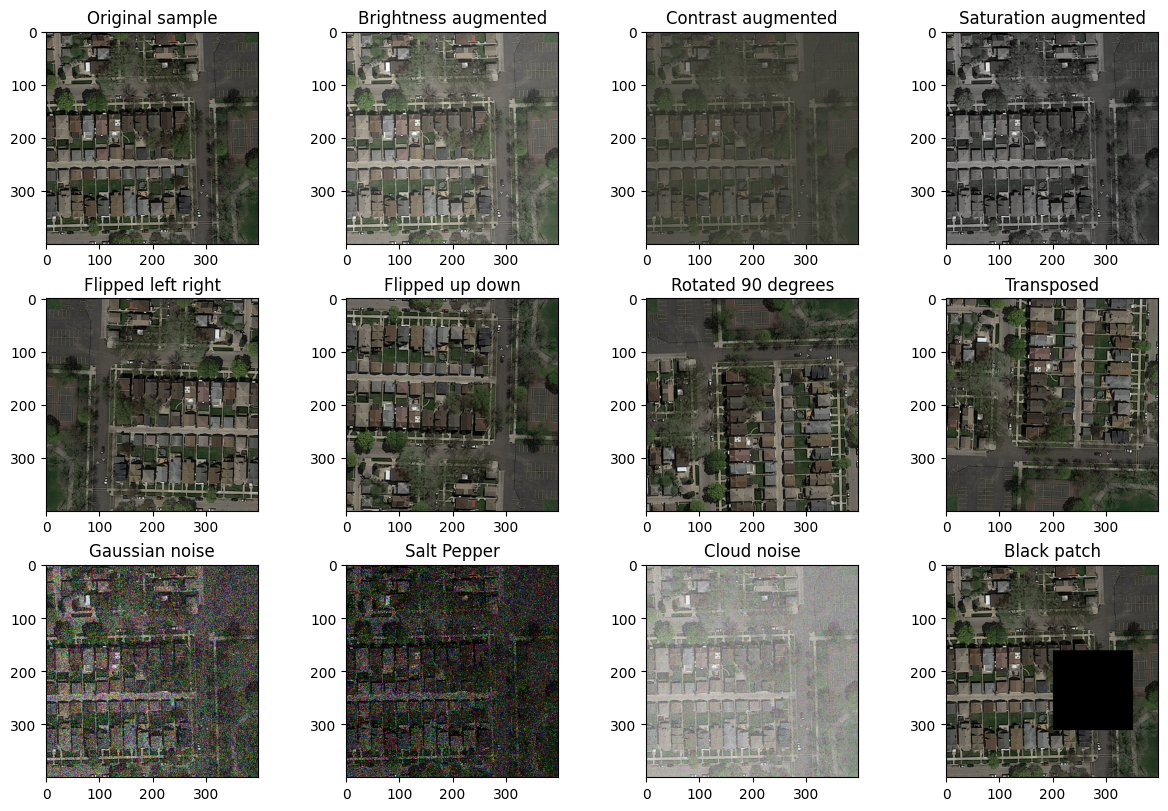

In [6]:
fig, axs = plt.subplots(3, 4, figsize = (12, 8), constrained_layout = True)

axs[0][0].imshow(sample_img)
axs[0][0].set_title('Original sample')
axs[0][1].imshow(brightness_augmented_img)
axs[0][1].set_title('Brightness augmented')
axs[0][2].imshow(contrast_augmented_img)
axs[0][2].set_title('Contrast augmented')
axs[0][3].imshow(saturation_augmented_img)
axs[0][3].set_title('Saturation augmented')

axs[1][0].imshow(flip_left_right_augmented_img)
axs[1][0].set_title('Flipped left right')
axs[1][1].imshow(flip_up_down_augmented_img)
axs[1][1].set_title('Flipped up down')
axs[1][2].imshow(rotated_augmented_img)
axs[1][2].set_title('Rotated 90 degrees')
axs[1][3].imshow(transposed_augmented_img)
axs[1][3].set_title('Transposed')

axs[2][0].imshow(gaussian_augmented_img)
axs[2][0].set_title('Gaussian noise')
axs[2][1].imshow(salt_pepper_augmented_img)
axs[2][1].set_title('Salt Pepper')
axs[2][2].imshow(cloud_noise_augmented_img)
axs[2][2].set_title('Cloud noise')
axs[2][3].imshow(black_patch_augmented_img)
axs[2][3].set_title('Black patch')

Text(0.5, 1.0, 'Black patch')

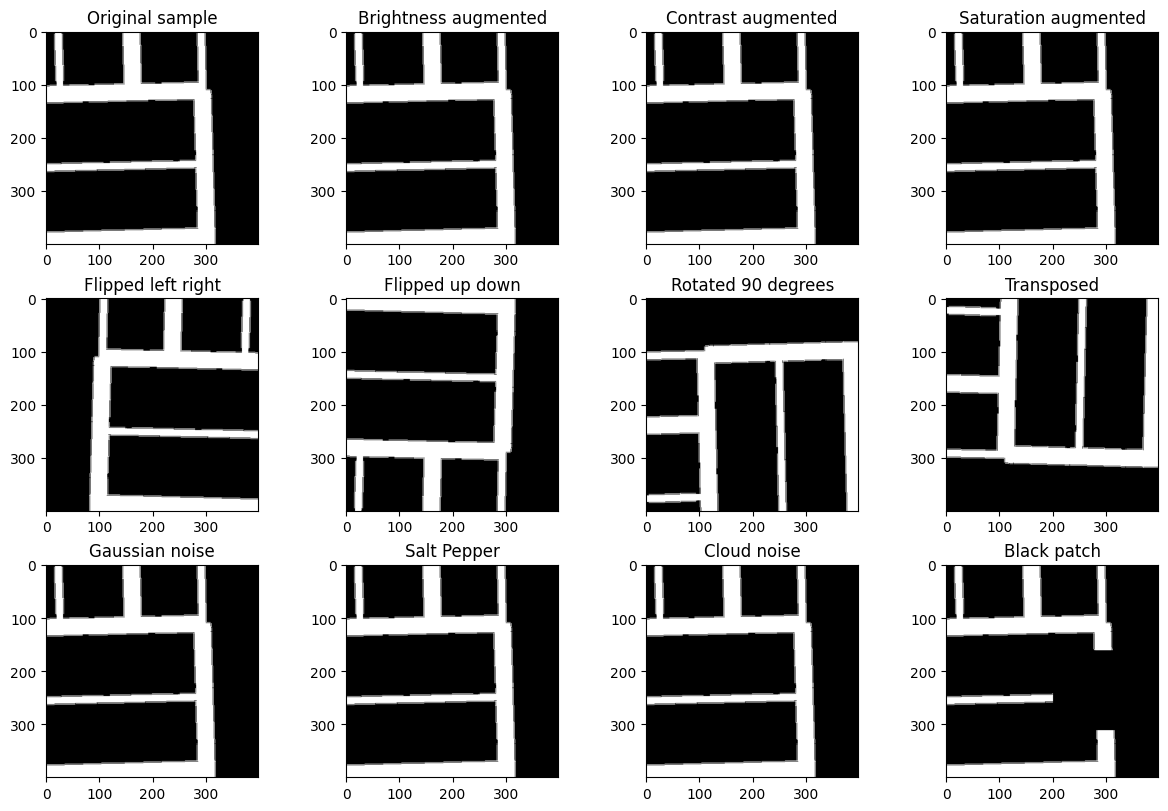

In [7]:
fig, axs = plt.subplots(3, 4, figsize = (12, 8), constrained_layout = True)

axs[0][0].imshow(sample_gt, cmap = 'gray')
axs[0][0].set_title('Original sample')
axs[0][1].imshow(brightness_augmented_gt, cmap = 'gray')
axs[0][1].set_title('Brightness augmented')
axs[0][2].imshow(contrast_augmented_gt, cmap = 'gray')
axs[0][2].set_title('Contrast augmented')
axs[0][3].imshow(saturation_augmented_gt, cmap = 'gray')
axs[0][3].set_title('Saturation augmented')

axs[1][0].imshow(flip_left_right_augmented_gt, cmap = 'gray')
axs[1][0].set_title('Flipped left right')
axs[1][1].imshow(flip_up_down_augmented_gt, cmap = 'gray')
axs[1][1].set_title('Flipped up down')
axs[1][2].imshow(rotated_augmented_gt, cmap = 'gray')
axs[1][2].set_title('Rotated 90 degrees')
axs[1][3].imshow(transposed_augmented_gt, cmap = 'gray')
axs[1][3].set_title('Transposed')

axs[2][0].imshow(gaussian_augmented_gt, cmap = 'gray')
axs[2][0].set_title('Gaussian noise')
axs[2][1].imshow(salt_pepper_augmented_gt, cmap = 'gray')
axs[2][1].set_title('Salt Pepper')
axs[2][2].imshow(cloud_noise_augmented_gt, cmap = 'gray')
axs[2][2].set_title('Cloud noise')
axs[2][3].imshow(black_patch_augmented_gt, cmap = 'gray')
axs[2][3].set_title('Black patch')